🔄 Loading transaction data...
Loaded 95,662 transactions
Columns: ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount', 'Value', 'TransactionStartTime', 'PricingStrategy', 'FraudResult']

🧮 Calculating RFM metrics...

🏷 Creating risk labels...


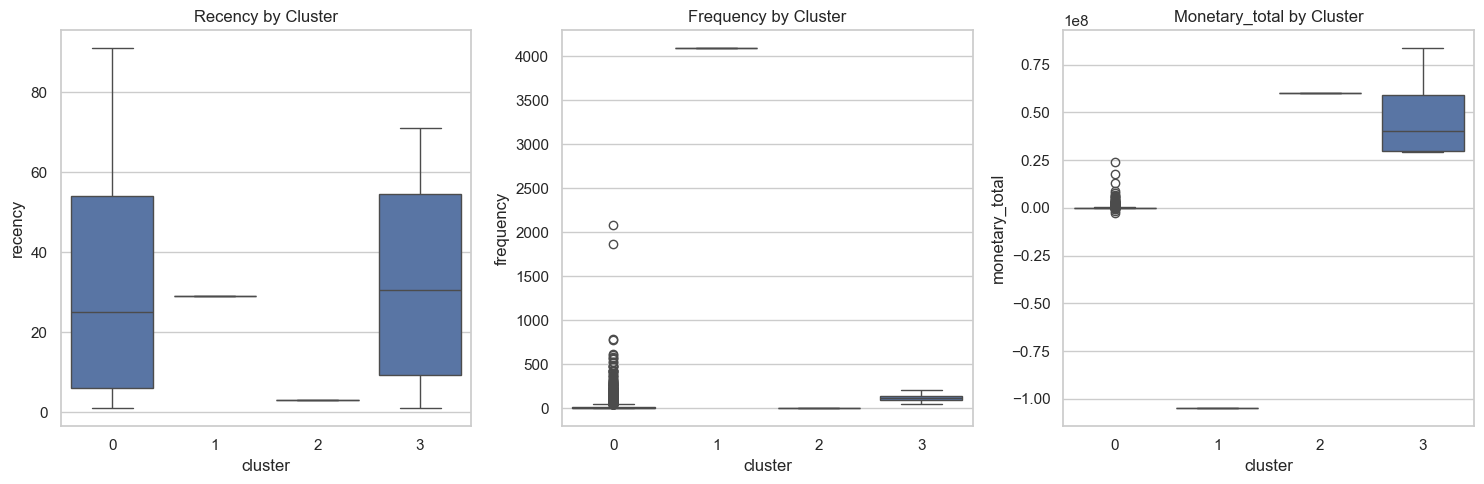


💾 Saving risk labels...

🔗 Merging features and targets...

Loading components...
Loading features from ..\data\processed\X_preprocessed.csv
Columns in features: ['num__Amount', 'num__Value', 'num__PricingStrategy', 'num__total_amount', 'num__avg_amount', 'num__std_amount', 'num__transaction_count', 'num__transaction_hour', 'num__transaction_day', 'num__transaction_month', 'num__transaction_year', 'num__max_amount', 'num__min_amount', 'num__avg_value', 'num__std_value', 'cat__CurrencyCode_UGX', 'cat__ProviderId_ProviderId_1', 'cat__ProviderId_ProviderId_2', 'cat__ProviderId_ProviderId_3', 'cat__ProviderId_ProviderId_4', 'cat__ProviderId_ProviderId_5', 'cat__ProviderId_ProviderId_6', 'cat__ProductId_ProductId_1', 'cat__ProductId_ProductId_10', 'cat__ProductId_ProductId_11', 'cat__ProductId_ProductId_13', 'cat__ProductId_ProductId_14', 'cat__ProductId_ProductId_15', 'cat__ProductId_ProductId_16', 'cat__ProductId_ProductId_19', 'cat__ProductId_ProductId_2', 'cat__ProductId_ProductId_20',

,CustomerId,recency,frequency,monetary_total,is_high_risk
0,CustomerId_1,84,1,-10000.0,0
1,CustomerId_10,84,1,-10000.0,0
2,CustomerId_1001,90,5,20000.0,0
3,CustomerId_1002,26,11,4225.0,0
4,CustomerId_1003,12,6,20000.0,0


In [5]:
# %% [markdown]
# # Proxy Target Variable Engineering

# %%
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import sys

sys.path.append('..')
from src import proxy_variable

# Configure display
pd.set_option('display.max_columns', 100)
sns.set_theme(style="whitegrid")
%matplotlib inline

# %%
# Configuration
RAW_DATA_PATH = Path('../data/raw/data.csv')
PROCESSED_DIR = Path('../data/processed')
CUSTOMER_ID = 'CustomerId'  # Make sure this matches your actual column name
DATE_COL = 'TransactionStartTime'
AMOUNT_COL = 'Amount'

# %%
# Load Raw Transaction Data
print("🔄 Loading transaction data...")
transactions = pd.read_csv(RAW_DATA_PATH, parse_dates=[DATE_COL])
print(f"Loaded {len(transactions):,} transactions")
print("Columns:", transactions.columns.tolist())  # Verify column names

# %%
# Calculate RFM Metrics
print("\n🧮 Calculating RFM metrics...")
rfm = proxy_variable.calculate_rfm(
    transactions,
    customer_id_col=CUSTOMER_ID,
    date_col=DATE_COL,
    amount_col=AMOUNT_COL
)

# Save RFM features
rfm_features = rfm.reset_index()[[CUSTOMER_ID, 'recency', 'frequency', 'monetary_total']]
rfm_features.to_csv(PROCESSED_DIR/'rfm_features.csv', index=False)

# %%
# Create Risk Labels
print("\n🏷 Creating risk labels...")
risk_labels = proxy_variable.create_risk_labels(rfm, n_clusters=4, plot=True)
risk_labels = risk_labels.reset_index()

# Save Targets
print("\n💾 Saving risk labels...")
PROCESSED_DIR.mkdir(exist_ok=True)
risk_labels[[CUSTOMER_ID, 'is_high_risk']].to_csv(PROCESSED_DIR/'targets.csv', index=False)

# %%
# Create Final Dataset
print("\n🔗 Merging features and targets...")

# Load all components with verification
print("\nLoading components...")
components = {
    'features': PROCESSED_DIR/'X_preprocessed.csv',
    'customer_ids': PROCESSED_DIR/'customer_ids.csv',
    'targets': PROCESSED_DIR/'targets.csv',
    'rfm_features': PROCESSED_DIR/'rfm_features.csv'
}

# Verify files exist and load them
dataframes = {}
for name, path in components.items():
    if path.exists():
        print(f"Loading {name} from {path}")
        dataframes[name] = pd.read_csv(path)
        print(f"Columns in {name}: {dataframes[name].columns.tolist()}")
    else:
        print(f"⚠️ Warning: {path} not found")

# Verify we have the required components
if 'customer_ids' not in dataframes:
    raise FileNotFoundError(f"Missing required file: {components['customer_ids']}")

# Merge step-by-step with verification
final_data = dataframes['customer_ids'].copy()
print("\nStarting merge process...")

# Merge features if available
if 'features' in dataframes:
    print("\nMerging features...")
    common_cols = set(final_data.columns) & set(dataframes['features'].columns)
    if common_cols:
        print(f"Common columns: {common_cols}")
    
    merge_col = CUSTOMER_ID if CUSTOMER_ID in dataframes['features'].columns else None
    if merge_col:
        final_data = final_data.merge(dataframes['features'], how='left', on=merge_col)
    else:
        print("⚠️ Could not merge features - no matching column")

# Merge RFM features
if 'rfm_features' in dataframes:
    print("\nMerging RFM features...")
    merge_col = CUSTOMER_ID if CUSTOMER_ID in dataframes['rfm_features'].columns else None
    if merge_col:
        final_data = final_data.merge(dataframes['rfm_features'], how='left', on=merge_col)
    else:
        print("⚠️ Could not merge RFM features - no matching column")

# Merge targets
if 'targets' in dataframes:
    print("\nMerging targets...")
    merge_col = CUSTOMER_ID if CUSTOMER_ID in dataframes['targets'].columns else None
    if merge_col:
        final_data = final_data.merge(dataframes['targets'], how='left', on=merge_col)
    else:
        print("⚠️ Could not merge targets - no matching column")

# Final validation
print("\n✅ Final dataset created!")
print(f"Shape: {final_data.shape}")
print("Columns:", final_data.columns.tolist())

# Show target distribution if available
if 'is_high_risk' in final_data.columns:
    print("\nTarget distribution:")
    print(final_data['is_high_risk'].value_counts(normalize=True))
else:
    print("\n⚠️ Target column not found in final data")

# %%
# Save and show results
final_data.to_csv(PROCESSED_DIR/'modeling_data.csv', index=False)
print(f"\n💾 Saved final modeling data to {PROCESSED_DIR/'modeling_data.csv'}")

# Show sample (only display columns that exist)
available_cols = [col for col in [CUSTOMER_ID, 'recency', 'frequency', 'monetary_total', 'is_high_risk'] 
                 if col in final_data.columns]
if available_cols:
    print("\nSample data:")
    display(final_data[available_cols].head())
else:
    print("\n⚠️ None of the requested columns are available")